Данные представляют собой 128 аудиофайлов человеческих голосов с 4 основными эмоциями: гнев, грусть, радость, страх по 32 файла каждого класса. Датасет сбалансирован.

In [1]:
import pandas as pd
import matplotlib.pyplot  as plt
import os
import librosa
import numpy as np
import random
import scipy
import keras
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as torch_data
import torch.nn.functional as F
import torch.nn.init as init
from scipy.io import wavfile
from scipy.fft import rfft, rfftfreq, irfft
from scipy import signal, stats
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix

my_seed = 42

random.seed(my_seed)

np.random.seed(my_seed)

torch.manual_seed(my_seed)
torch.cuda.manual_seed(my_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

В данном проекте ставится задача 4-классовой классификации аудио по эмоциям на основе аудиофункциональных и спектральных характеристик.

### Метки классов

гнев - 0

грусть - 1

радость - 2

страх - 3

### Загрузка данных

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
dir = "/content/drive/MyDrive/"

In [4]:
dirname_anger = os.path.join(dir, 'data', 'гнев')
audio_anger = [os.path.join(dirname_anger, file) for file in os.listdir(dirname_anger) if file.endswith('.wav')]

dirname_sad = os.path.join(dir, 'data', 'грусть')
audio_sad = [os.path.join(dirname_sad, file) for file in os.listdir(dirname_sad) if file.endswith('.wav')]

dirname_happy = os.path.join(dir, 'data', 'радость')
audio_happy = [os.path.join(dirname_happy, file) for file in os.listdir(dirname_happy) if file.endswith('.wav')]

dirname_fear = os.path.join(dir, 'data', 'страх')
audio_fear = [os.path.join(dirname_fear, file) for file in os.listdir(dirname_fear) if file.endswith('.wav')]

Подготавливаем словарь для создания датафрейма.

In [5]:
data = {}
data[0] = audio_anger
data[1] = audio_sad
data[2] = audio_happy
data[3] = audio_fear

Визуализация рядов

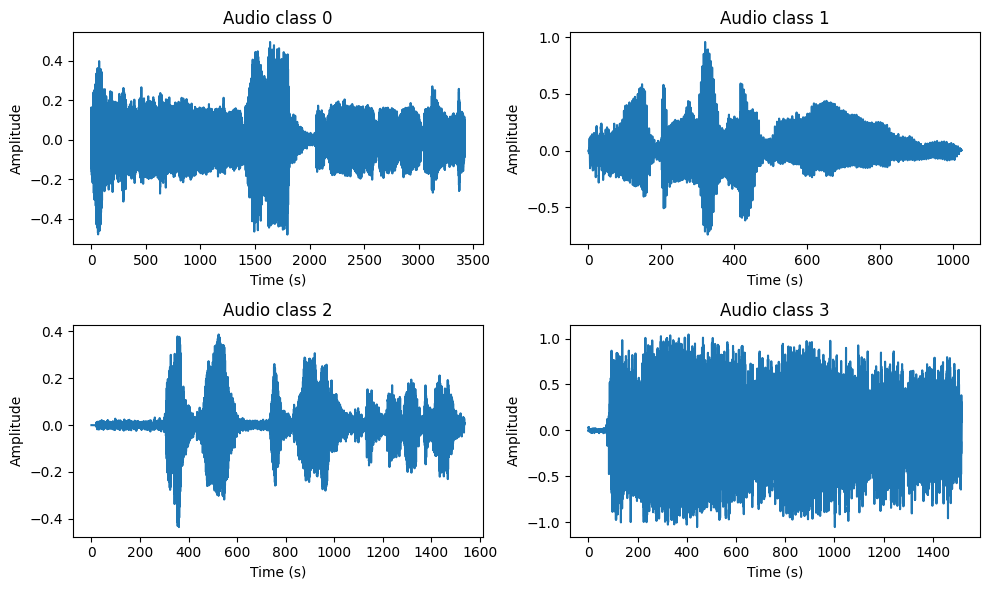

In [ ]:
import librosa
import matplotlib.pyplot as plt

audio_files = [audio_anger[0], audio_sad[0], audio_happy[0], audio_fear[0]]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))

for i, audio_file in enumerate(audio_files):
    audio, sr = librosa.load(audio_file)
    time = librosa.times_like(audio, sr=sr)

    row = i // 2
    col = i % 2

    axes[row, col].plot(time, audio)
    axes[row, col].set_xlabel('Time (s)')
    axes[row, col].set_ylabel('Amplitude')
    axes[row, col].set_title(f'Audio class {i}')

plt.tight_layout()

plt.show()

### Анализ аудиофункциональных и спектральных характеристик.

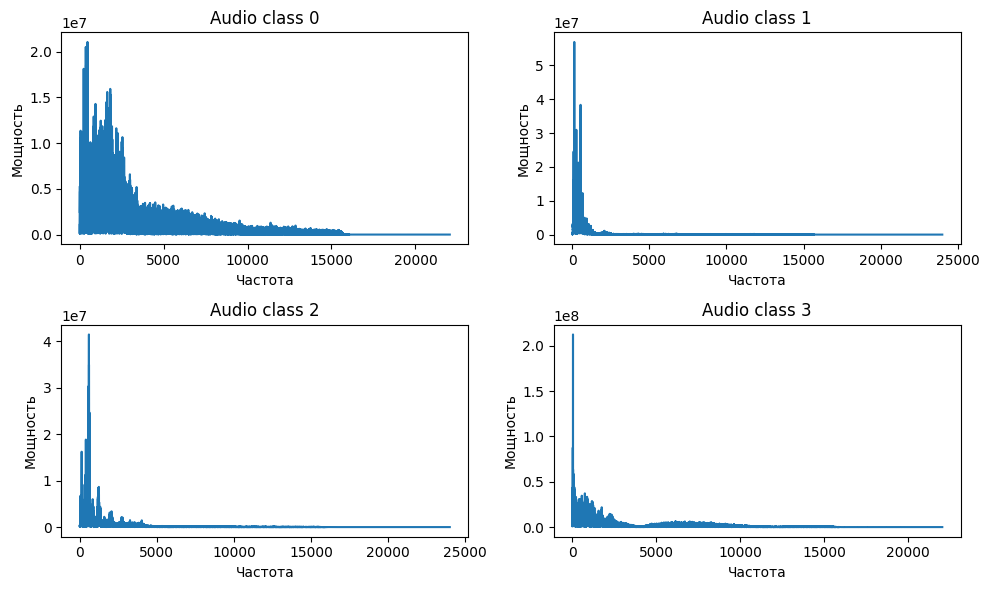

In [ ]:
audio_files = [audio_anger[0], audio_sad[0], audio_happy[0], audio_fear[0]]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))

for i, audio_file in enumerate(audio_files):
    samplerate, data = wavfile.read(audio_file)
    duration = len(data) / samplerate

    N = int(samplerate * duration)

    if data.ndim == 2:
        yf = rfft(data[:, 0])
    else:
        yf = rfft(data)
    xf = rfftfreq(N, 1 / samplerate)

    row = i // 2
    col = i % 2

    axes[row, col].plot(xf, np.abs(yf))
    axes[row, col].set_xlabel('Частота')
    axes[row, col].set_ylabel('Мощность')
    axes[row, col].set_title(f'Audio class {i}')

plt.tight_layout()
plt.show()

 По графикам видно, что в основном преобладают частоты ниже 5000 Гц для всех классов. Для класса 0 немного выделяются высокие частоты.

Мел-кепстральные коэффициенты (MFCC)

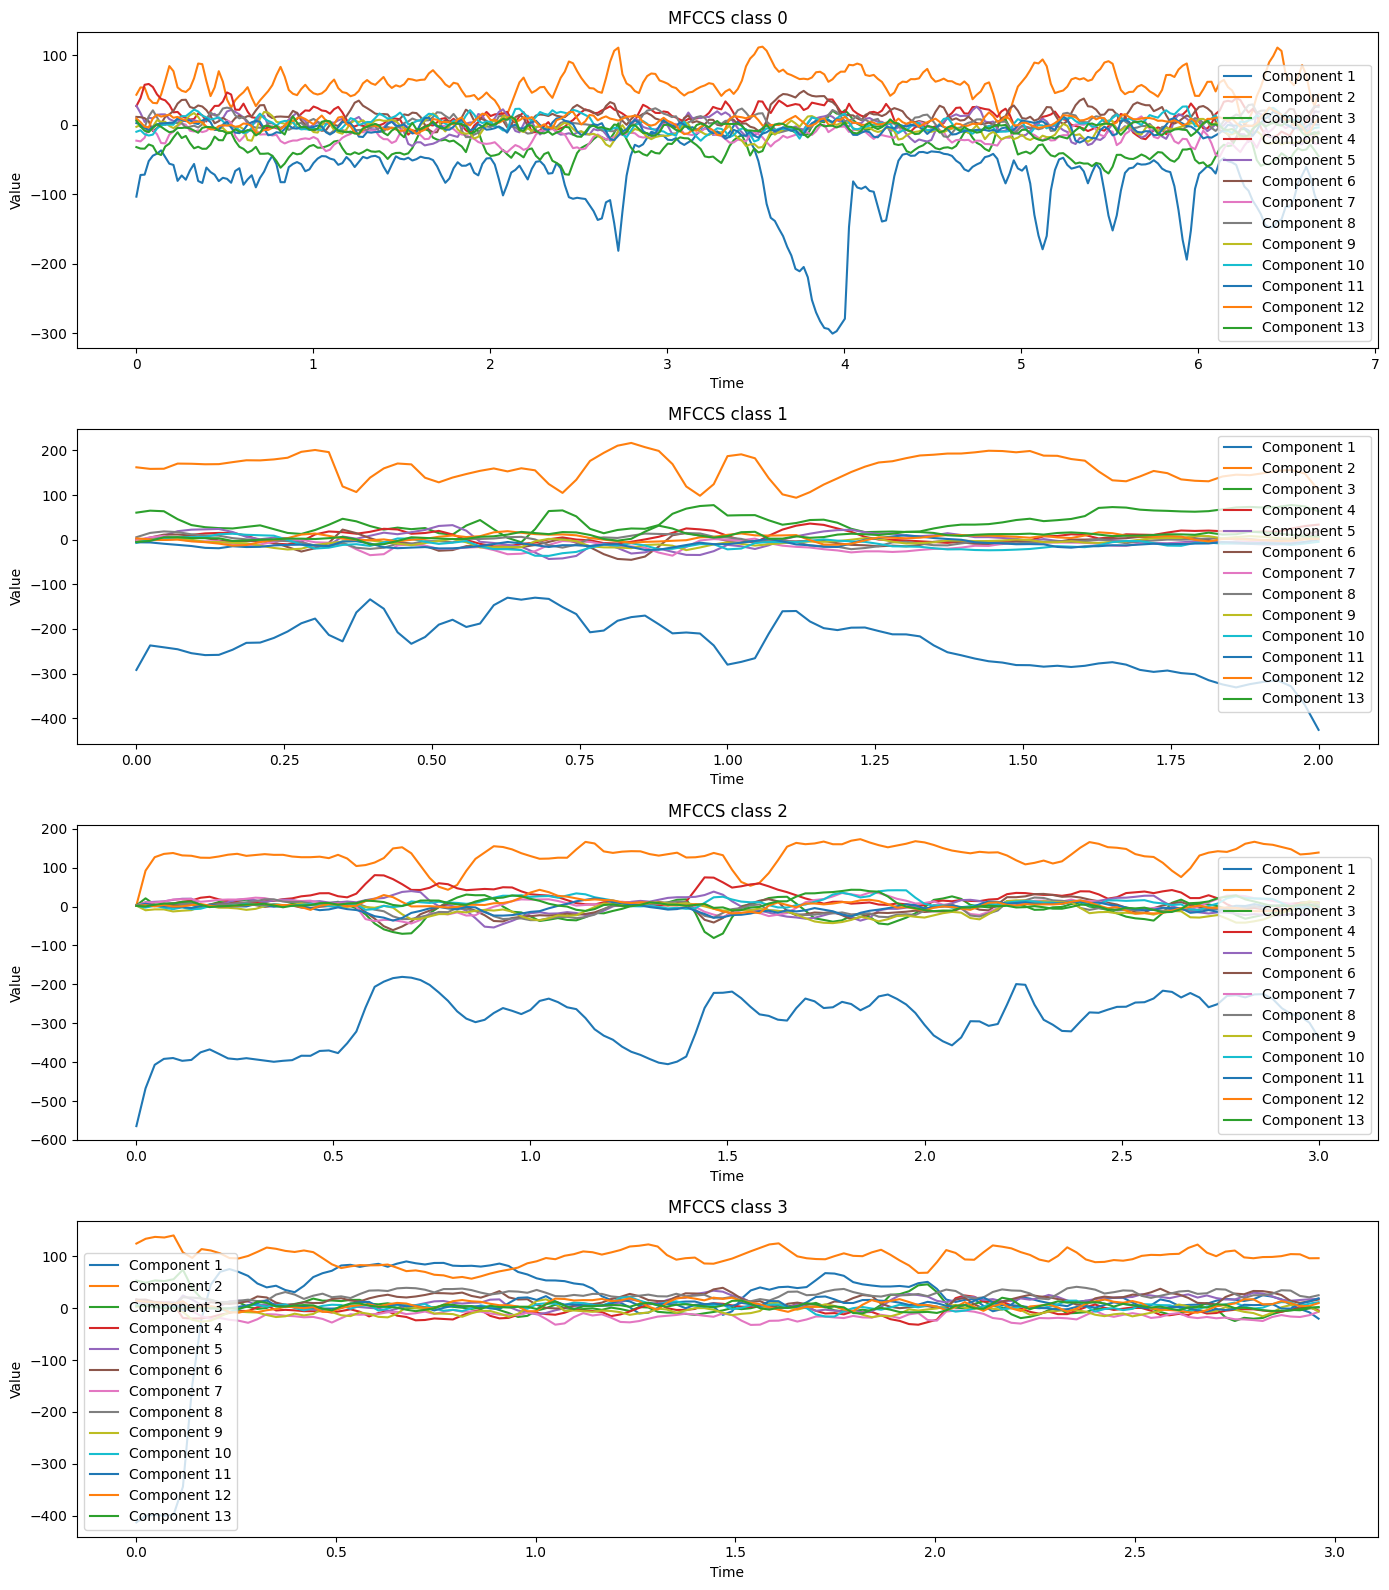

In [ ]:
audio_files = [audio_anger[0], audio_sad[0], audio_happy[0], audio_fear[0]]
features = []
durations = []
times = []

fig, axes = plt.subplots(4, 1, figsize=(14, 16))

for i, audio_file in enumerate(audio_files):
    audio, sr = librosa.load(audio_file)
    feature = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
    duration = librosa.get_duration(y=audio, sr=sr)
    time = np.linspace(0, duration, num=feature.shape[1])

    features.append(feature)
    durations.append(duration)
    times.append(time)

    for j in range(feature.shape[0]):
        axes[i].plot(time, feature[j, :], label=f'Component {j+1}')
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Value')
    axes[i].set_title(f'MFCCS class {i}')
    axes[i].legend()

plt.tight_layout()

plt.show()

По графикам видно, что амплитуда звука сильнее меняется во времени у злости и радости. Меньше всего меняется у страха.

### Извлечение свойств:

Извлекаем из аудио мел-кепстральные коэффициенты и отбираем из них те, которые являются статистически отличаются у разных класссов. Отбор делаем с помощью U-критерия Манна — Уитни.

In [6]:
def extract_features(file_paths_dict):
    data = {'filename': [], 'emotion_label': []}
    mfcc_columns = [f'mfcc_{i}' for i in range(13)]

    for label, paths in file_paths_dict.items():
        for path in paths:
            y, sr = librosa.load(path)

            mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

            data['filename'].append(path)
            data['emotion_label'].append(label)

            for i, col in enumerate(mfcc_columns):
                data[col] = data.get(col, []) + [np.mean(mfcc[i])]

    df = pd.DataFrame(data)

    selected_mfcc_columns = []
    for col in mfcc_columns:
        for label in df['emotion_label'].unique():
            for other_label in df['emotion_label'].unique():
                if label != other_label:
                    label_data = df[df['emotion_label'] == label][col]
                    other_label_data = df[df['emotion_label'] == other_label][col]
                    _, p_value = stats.mannwhitneyu(label_data, other_label_data)

                    if p_value < 0.05:
                        print(f"Statistically significant difference found for {col} between {label} and {other_label}")
                        if col not in selected_mfcc_columns:
                            selected_mfcc_columns.append(col)

    df = df[['filename'] + selected_mfcc_columns + ['emotion_label']]

    return df

df = extract_features(data)

Statistically significant difference found for mfcc_0 between 0 and 1
Statistically significant difference found for mfcc_0 between 0 and 2
Statistically significant difference found for mfcc_0 between 1 and 0
Statistically significant difference found for mfcc_0 between 1 and 2
Statistically significant difference found for mfcc_0 between 1 and 3
Statistically significant difference found for mfcc_0 between 2 and 0
Statistically significant difference found for mfcc_0 between 2 and 1
Statistically significant difference found for mfcc_0 between 2 and 3
Statistically significant difference found for mfcc_0 between 3 and 1
Statistically significant difference found for mfcc_0 between 3 and 2
Statistically significant difference found for mfcc_1 between 0 and 1
Statistically significant difference found for mfcc_1 between 0 and 3
Statistically significant difference found for mfcc_1 between 1 and 0
Statistically significant difference found for mfcc_1 between 3 and 0
Statistically signif

In [9]:
df

,filename,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_9,mfcc_10,mfcc_12,emotion_label
0,/content/drive/MyDrive/data/гнев/гнев23-1.wav,-79.261391,59.106838,-31.721300,11.329988,-2.283596,12.213952,-15.267756,3.019697,1.782045,-4.397264,-5.418225,0
1,/content/drive/MyDrive/data/гнев/гнев27-1.wav,-54.839207,58.140217,-25.408955,27.474560,-14.729074,-9.805650,-10.675034,-2.383044,10.903616,-6.600509,-6.980516,0
2,/content/drive/MyDrive/data/гнев/гнев6-1.wav,-222.658447,96.782822,-61.242405,30.923004,12.366464,0.887719,1.490686,33.547207,13.904383,15.879919,4.492134,0
3,/content/drive/MyDrive/data/гнев/гнев10-1.wav,-269.116791,78.869820,-5.549602,13.893893,3.012233,-5.066640,-24.334179,0.849071,-8.177711,-5.711013,-17.575928,0
4,/content/drive/MyDrive/data/гнев/гнев21-1.wav,-93.580566,71.580299,-25.721161,15.809422,-4.877267,3.293370,-11.126314,0.392728,5.933300,0.389876,-0.256030,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,/content/drive/MyDrive/data/страх/страх_2-2.wav,-198.849518,83.890121,-14.678594,28.283470,-10.354869,6.826674,-15.438246,0.587515,-3.203765,-4.319821,-9.756801,3
124,/content/drive/MyDrive/data/страх/страх_11-2.wav,-198.358231,53.671806,0.769895,17.143608,-29.828640,11.770060,-17.292139,-4.965791,-8.969187,-7.168793,-9.890387,3
125,/content/drive/MyDrive/data/страх/страх_7-2.wav,-299.847961,119.124557,-17.793982,12.626238,-13.828918,13.176262,-5.637086,6.187976,-4.728627,-8.892084,0.050645,3
126,/content/drive/MyDrive/data/страх/страх_23-2.wav,12.905975,85.904037,-15.694260,13.970978,-14.284503,4.298841,-3.813371,-0.275755,-4.444637,-5.363654,-2.648642,3


In [7]:
y = df["emotion_label"]
del df["emotion_label"]
del df["filename"]

Делаем разбиение на трейн и тест, сохраняющее соотношение классов, представленное в исходном датасете.

In [8]:
X = df

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.15,
    random_state=my_seed,
    stratify=y
)

In [ ]:
df

,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_9,mfcc_10,mfcc_12
0,-79.261391,59.106838,-31.721300,11.329988,-2.283596,12.213952,-15.267756,3.019697,1.782045,-4.397264,-5.418225
1,-54.839207,58.140217,-25.408955,27.474560,-14.729074,-9.805650,-10.675034,-2.383044,10.903616,-6.600509,-6.980516
2,-222.658447,96.782822,-61.242405,30.923004,12.366464,0.887719,1.490686,33.547207,13.904383,15.879919,4.492134
3,-269.116791,78.869820,-5.549602,13.893893,3.012233,-5.066640,-24.334179,0.849071,-8.177711,-5.711013,-17.575928
4,-93.580566,71.580299,-25.721161,15.809422,-4.877267,3.293370,-11.126314,0.392728,5.933300,0.389876,-0.256030
...,...,...,...,...,...,...,...,...,...,...,...
123,-198.849518,83.890121,-14.678594,28.283470,-10.354869,6.826674,-15.438246,0.587515,-3.203765,-4.319821,-9.756801
124,-198.358231,53.671806,0.769895,17.143608,-29.828640,11.770060,-17.292139,-4.965791,-8.969187,-7.168793,-9.890387
125,-299.847961,119.124557,-17.793982,12.626238,-13.828918,13.176262,-5.637086,6.187976,-4.728627,-8.892084,0.050645
126,12.905975,85.904037,-15.694260,13.970978,-14.284503,4.298841,-3.813371,-0.275755,-4.444637,-5.363654,-2.648642


### Модель 1.

Классический алгоритм - случайный лес.

Подбираем параметры с помощью Random Search

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'n_estimators': [200, 250, 300, 350, 400],
    'max_depth': [15, 20, 25, 30, 35],
    'min_samples_split': [2, 3, 4, 5, 6],
    'min_samples_leaf': [1, 2, 3, 4, 5]
}

classifier = RandomForestClassifier()

random_search = RandomizedSearchCV(
    estimator=classifier,
    param_distributions=param_grid,
    cv=5,
    scoring='accuracy'
)

random_search.fit(X_train, y_train)

best_params = random_search.best_params_
best_score = random_search.best_score_

print("best_params:", best_params)
print("best_score", best_score)

best_params: {'n_estimators': 200, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_depth': 15}
best_score 0.648051948051948


In [31]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier


# Ранее с помощью Random Search были подобраны лучшие параметры
# Параметры в ячейке выше - просто эксперименты, которые показывают качество похуже
best_classifier = RandomForestClassifier(
    n_estimators=250,
    min_samples_split=3,
    min_samples_leaf=1,
    max_depth=30,
    random_state=my_seed
)
best_classifier.fit(X_train, y_train)

y_pred = best_classifier.predict(X_test)
y_pred_proba = best_classifier.predict_proba(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
print("Roc_auc:", roc_auc)

precision = precision_score(y_test, y_pred, average='macro')
print("Precision:", precision)

recall = recall_score(y_test, y_pred, average='macro')
print("Recall:", recall)

f1 = f1_score(y_test, y_pred, average='macro')
print("F1 score:", f1)

Accuracy: 0.9
Roc_auc: 0.9466666666666667
Precision: 0.9083333333333333
Recall: 0.8999999999999999
F1 score: 0.8994949494949496


Accuracy - хорошо.

Roc_auc - очень хорошо, близко к 1

Precision, Recall, F1 - хорошо

In [9]:
def view_roc_curve(y_test, y_pred_proba):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(4):
        fpr[i], tpr[i], _ = roc_curve(y_test, y_pred_proba[:, i], pos_label=i)
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(15, 6))

    # ROC curve
    plt.subplot(1, 2, 1)
    for i in range(4):
        plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (area = {roc_auc[i]:0.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")

    plt.tight_layout()
    plt.show()

In [10]:
def plot_metrics_matrix(y_true, y_pred):
    classes = np.unique(np.concatenate((y_true, y_pred)))
    cm = confusion_matrix(y_true, y_pred)

    metrics = []
    # Вычисление метрик для каждого класса
    for i in range(len(classes)):
        TP = cm[i, i]
        FN = np.sum(cm[i, :]) - TP
        FP = np.sum(cm[:, i]) - TP
        TN = np.sum(cm) - (TP + FP + FN)

        TPR = TP / (TP + FN)
        TNR = TN / (TN + FP)
        FPR = FP / (FP + TN)
        FNR = FN / (TP + FN)

        metrics.append([TPR, TNR, FPR, FNR])

    metrics = np.array(metrics)
    metric_names = ['TPR', 'TNR', 'FPR', 'FNR']

    plt.figure(figsize=(8, 6))
    sns.heatmap(metrics, annot=True, cmap='YlGnBu', fmt='.4f', xticklabels=metric_names, yticklabels=classes)
    plt.xlabel('Metrics')
    plt.ylabel('Classes')
    plt.title('Metrics Matrix for each class')
    plt.show()

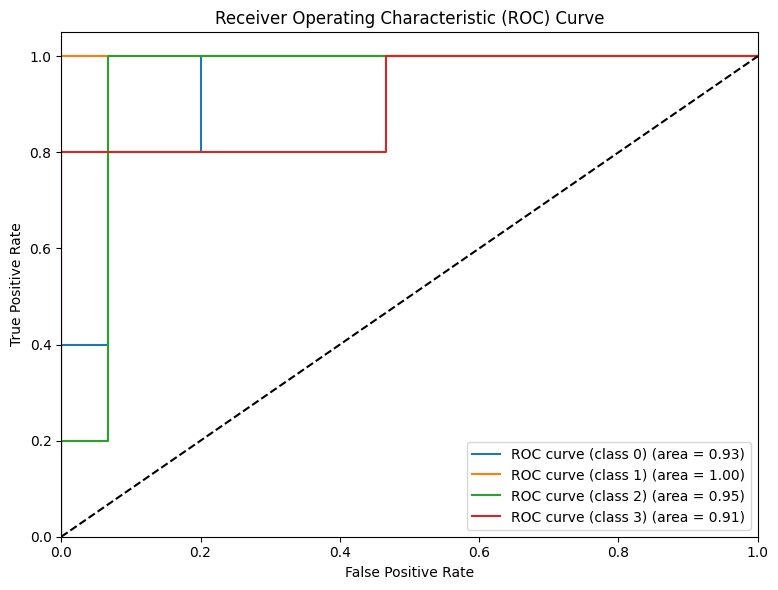

In [ ]:
view_roc_curve(y_test, y_pred_proba)

По указанным значениям видно, что лес достаточно хорошо умеет различать эмоции. Лучше всего она умеет распознавать грусть и радость.

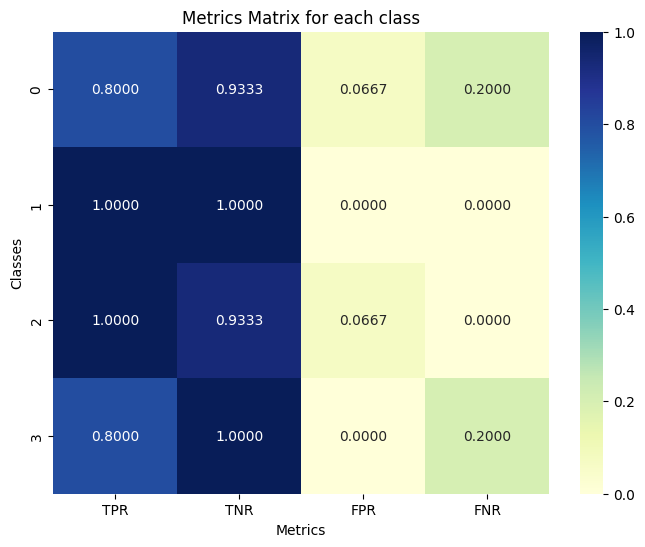

In [ ]:
plot_metrics_matrix(y_test, y_pred)

Лес хорошо умеет различать грусть и радость от других эмоций, неплохо - гнев и страх.

### Модель 2.

Классический алгоритм - градиентный бустинг.

Подбираем параметры с помощью Random Search

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from scipy.stats import randint as sp_randint

param_dist = {
    "n_estimators": sp_randint(50, 500),
    "learning_rate": [0.001, 0.01, 0.1, 0.2, 0.3],
    "max_depth": sp_randint(3, 10),
    "subsample": [0.5, 0.7, 0.9, 1.0],
    "min_samples_split": sp_randint(2, 20),
    "min_samples_leaf": sp_randint(1, 20)
}

classifier = GradientBoostingClassifier()

random_search = RandomizedSearchCV(
    estimator=classifier,
    param_distributions=param_dist,
    n_iter=20,
    cv=5,
    scoring='accuracy'
)

random_search.fit(X_train, y_train)

best_params = random_search.best_params_
best_score = random_search.best_score_

print("best_params:", best_params)
print("best_score", best_score)

best_params: {'learning_rate': 0.2, 'max_depth': 6, 'min_samples_leaf': 10, 'min_samples_split': 7, 'n_estimators': 366, 'subsample': 0.7}
best_score 0.6389610389610388


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier


# Ранее с помощью Random Search были подобраны лучшие параметры
# Параметры в ячейке выше - просто эксперименты, которые показывают качество похуже
best_classifier = GradientBoostingClassifier(
    learning_rate=0.2,
    max_depth=6,
    min_samples_leaf=10,
    min_samples_split=7,
    n_estimators=366,
    subsample=0.7,
    random_state=my_seed
)
best_classifier.fit(X_train, y_train)

y_pred = best_classifier.predict(X_test)
y_pred_proba = best_classifier.predict_proba(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
print("Roc_auc:", roc_auc)

precision = precision_score(y_test, y_pred, average='macro')
print("Precision:", precision)

recall = recall_score(y_test, y_pred, average='macro')
print("Recall:", recall)

f1 = f1_score(y_test, y_pred, average='macro')
print("F1 score:", f1)

Accuracy: 0.9
Roc_auc: 0.9566666666666667
Precision: 0.9285714285714286
Recall: 0.8999999999999999
F1 score: 0.9027777777777778


Accuracy - хорошо.

Roc_auc - очень хорошо, близко к 1

Precision, Recall, F1 - хорошо

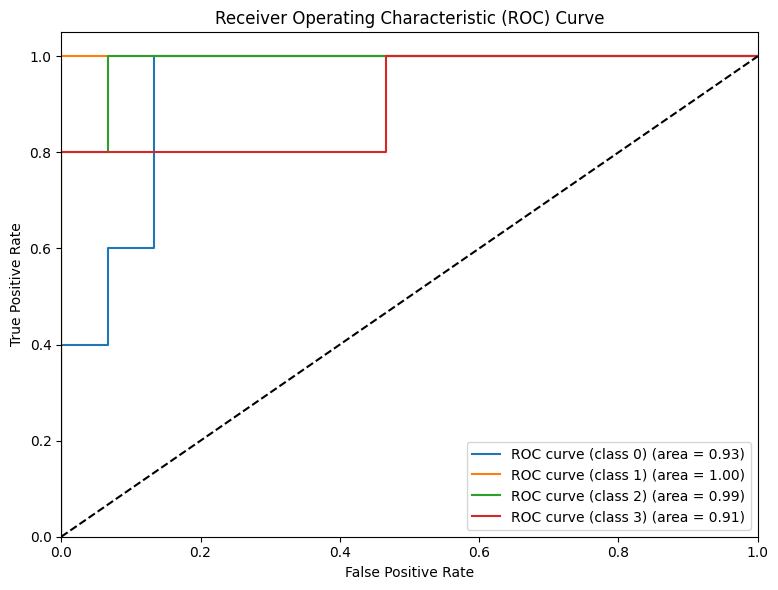

In [ ]:
view_roc_curve(y_test, y_pred_proba)

По указанным значениям видно, что модель достаточно хорошо умеет различать эмоции. Лучше всего она умеет распознавать грусть и радость.

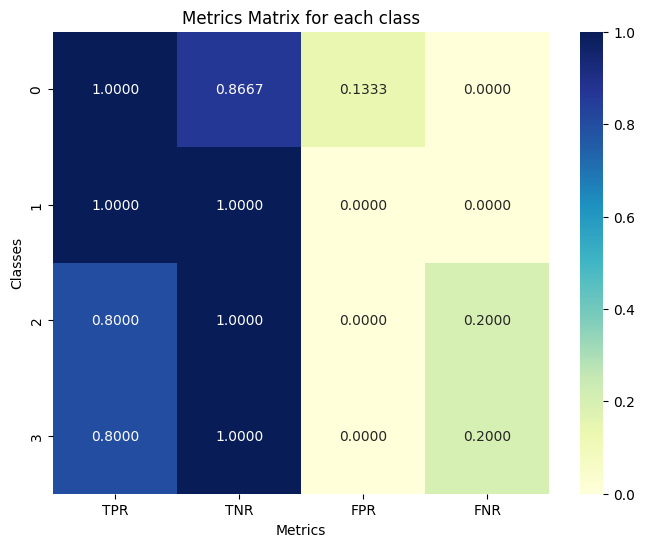

In [ ]:
plot_metrics_matrix(y_test, y_pred)

Модель отлично умеет различать грусть от других эмоций, неплохо - гнев, радость и страх.

### Подготовка данных для нейросетей.

In [11]:
X_train_np = X_train.to_numpy()
y_train_np = y_train.to_numpy()
X_test_np = X_test.to_numpy()
y_test_np = y_test.to_numpy()

X_train_tensor = torch.FloatTensor(X_train_np)
y_train_tensor = torch.LongTensor(y_train_np)
X_test_tensor = torch.FloatTensor(X_test_np)
y_test_tensor = torch.LongTensor(y_test_np)

batch_size = 8
train_dataset = torch_data.TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = torch_data.TensorDataset(X_test_tensor, y_test_tensor)

train_dataloader = torch_data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch_data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Модель 3.

Нейросеть LSTM c 1 сверточным слоем, 3 lstm слоями и 1 линейным.

На выходе - логарифм функции softmax от линейного преобразования.

Функция активации - LeakyReLU (лучше всего работает)

Функция потерь - Negative Log Likelihood Loss для log_softmax.

Оптимизатор - AdamW.

В ходе экспериментов log_softmax на выходе работает лучше, чем softmax.


In [67]:
class LSTMModel(nn.Module):
    def __init__(self):
        super(LSTMModel, self).__init__()
        self.hidden_size = 128
        self.num_layers = 3

        self.conv1 = nn.Conv1d(in_channels=1, out_channels=128, kernel_size=5, stride=2, padding=2)
        self.leakyelu = nn.LeakyReLU(negative_slope=0.2)
        self.maxpool = nn.MaxPool1d(kernel_size=2)

        self.lstm = nn.LSTM(128, self.hidden_size, self.num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(self.hidden_size, 4)

    def forward(self, x):
        batch_size = x.size(0)
        seq_len = x.size(1)

        x = x.view(batch_size, seq_len, -1)

        x = x.permute(0, 2, 1)
        x = self.conv1(x)
        x = self.leakyelu(x)
        x = self.maxpool(x)
        x = x.permute(0, 2, 1)

        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))

        out = self.fc(out[:, -1, :])
        out = F.log_softmax(out, dim=1)
        return out


In [33]:
def train_model(model, loader, loss_fn, optimizer, n_epochs):
    model.train()

    train_losses = []
    test_losses = []

    for epoch in range(1, n_epochs + 1):
        for X_batch, y_batch in loader:
            X_batch = X_batch.float()
            y_batch = y_batch.long()
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # После каждой эпохи оцениваем модель на тестовом наборе данных
        model.eval()
        with torch.no_grad():
            y_pred_train = model(X_train_tensor)
            predicted_classes_train = torch.argmax(y_pred_train, axis=1)
            train_acc = accuracy_score(predicted_classes_train.cpu().numpy(), y_train_tensor.cpu().numpy())

            y_pred_test = model(X_test_tensor)
            predicted_classes_test = torch.argmax(y_pred_test, axis=1)
            test_acc = accuracy_score(predicted_classes_test.cpu().numpy(), y_test_tensor.cpu().numpy())

            print("Epoch %d: train accuracy %.4f, test accuracy %.4f" % (epoch, train_acc, test_acc))

    return model


In [68]:
loss_fn = nn.NLLLoss()
model = LSTMModel()
optimizer = optim.AdamW(model.parameters())

In [69]:
n_epochs = 100
model = train_model(model, train_dataloader, loss_fn, optimizer, n_epochs)

Epoch 1: train accuracy 0.5185, test accuracy 0.5000
Epoch 2: train accuracy 0.7222, test accuracy 0.7000
Epoch 3: train accuracy 0.7037, test accuracy 0.7500
Epoch 4: train accuracy 0.7500, test accuracy 0.7500
Epoch 5: train accuracy 0.8796, test accuracy 0.7500
Epoch 6: train accuracy 0.8796, test accuracy 0.8000
Epoch 7: train accuracy 0.9074, test accuracy 0.7000
Epoch 8: train accuracy 0.8426, test accuracy 0.7500
Epoch 9: train accuracy 0.9259, test accuracy 0.7000
Epoch 10: train accuracy 0.9815, test accuracy 0.8500
Epoch 11: train accuracy 0.9815, test accuracy 0.8500
Epoch 12: train accuracy 0.9444, test accuracy 0.7000
Epoch 13: train accuracy 0.9907, test accuracy 0.8500
Epoch 14: train accuracy 0.8796, test accuracy 0.7000
Epoch 15: train accuracy 0.9815, test accuracy 0.7000
Epoch 16: train accuracy 0.9722, test accuracy 0.8500
Epoch 17: train accuracy 1.0000, test accuracy 0.8000
Epoch 18: train accuracy 0.9722, test accuracy 0.8000
Epoch 19: train accuracy 0.9907, test

Нейросеть в функции train_model обучается на тренировочном лодере. Но качество предсказаний отслеживается на тренировочном и на тестовом, чтобы понять обобщающую способность модели.

In [13]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
import torch

def calculate_accuracy(y_pred, y_true):
    accuracy = accuracy_score(y_pred, y_true)
    return accuracy

def calculate_roc_auc(y_pred_prob, y_true):
    roc_auc = roc_auc_score(y_true, y_pred_prob, multi_class='ovr')
    return roc_auc

def calculate_precision(y_pred, y_true):
    precision = precision_score(y_true, y_pred, average='weighted')
    return precision

def calculate_recall(y_pred, y_true):
    recall = recall_score(y_true, y_pred, average='weighted')
    return recall

def calculate_f1_score(y_pred, y_true):
    f1 = f1_score(y_true, y_pred, average='weighted')
    return f1

def get_predictions(model, dataloader):
    model.eval()
    predictions = []
    true_labels = []
    y_pred_prob = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, dim=1)
            predictions.extend(predicted.tolist())
            true_labels.extend(labels.tolist())
            y_pred_prob.extend(torch.nn.functional.softmax(outputs, dim=1).tolist())

    return predictions, true_labels, y_pred_prob

In [12]:
def view_roc_curve_nn(y_test, y_pred_proba):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = len(y_pred_proba[0])

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test, [pred[i] for pred in y_pred_proba], pos_label=i)
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(8, 6))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (area = {roc_auc[i]:0.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

In [70]:
test_predictions, true_labels, y_pred_prob = get_predictions(model, test_dataloader)

accuracy = calculate_accuracy(test_predictions, true_labels)
roc_auc = calculate_roc_auc(y_pred_prob, true_labels)
precision = calculate_precision(test_predictions, true_labels)
recall = calculate_recall(test_predictions, true_labels)
f1 = calculate_f1_score(test_predictions, true_labels)

print("LSTM")
print(f'Accuracy: {accuracy}')
print(f'ROC AUC: {roc_auc}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')


LSTM
Accuracy: 0.85
ROC AUC: 0.8966666666666667
Precision: 0.8583333333333334
Recall: 0.85
F1 Score: 0.8494949494949496


Accuracy - в целом, нормально

Roc_auc - неплохо

Precision, Recall, F1 - неплохо

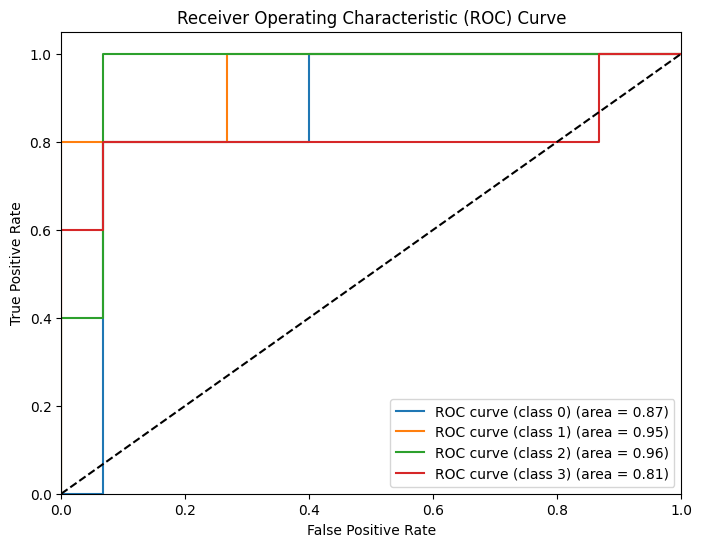

In [71]:
view_roc_curve_nn(true_labels, y_pred_prob)

По указанным значениям видно, что модель достаточно хорошо умеет различать эмоции. Лучше всего она умеет распознавать грусть и радость.

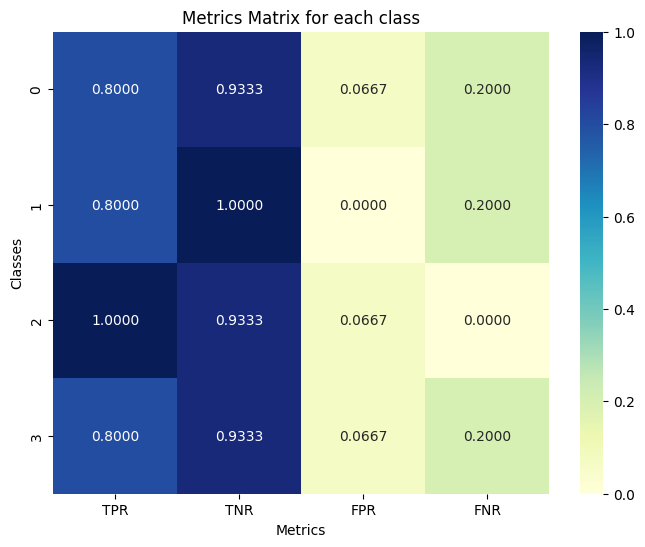

In [72]:
plot_metrics_matrix(true_labels, test_predictions)

Модель лучше всего умеет различать радость от других эмоций, отлично отличает другие эмоции от грусти, неплохо различает гнев и страх.

### Модель 4.

Рекурентная нейронная сеть c 3 RNN слоями и 3 полносвязными.

На выходе - логарифм функции softmax от линейного преобразования.

Функция активации - ELU (лучше всего работает)

Функция потерь - Negative Log Likelihood Loss для log_softmax.

Оптимизатор - Adam.

В ходе экспериментов log_softmax на выходе работает лучше, чем softmax.


In [73]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.hidden_size = 256
        self.num_layers = 3
        self.rnn = nn.RNN(1, 256, 3, batch_first=True)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 4)
        self.elu = nn.ELU()

    def forward(self, x):
        batch_size = x.size(0)
        seq_len = x.size(1)
        x = x.view(batch_size, seq_len, -1)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc1(out[:, -1, :])
        out = self.elu(out)
        out = self.fc2(out)
        out = self.elu(out)
        out = self.fc3(out)
        out = self.elu(out)
        out = self.fc4(out)
        out = F.log_softmax(out, dim=1)
        return out

In [74]:
loss_fn = nn.NLLLoss()
model = RNN()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [75]:
n_epochs = 100
model = train_model(model, train_dataloader, loss_fn, optimizer, n_epochs)

Epoch 1: train accuracy 0.5093, test accuracy 0.4500
Epoch 2: train accuracy 0.3981, test accuracy 0.3500
Epoch 3: train accuracy 0.5370, test accuracy 0.3500
Epoch 4: train accuracy 0.6389, test accuracy 0.5500
Epoch 5: train accuracy 0.6759, test accuracy 0.7000
Epoch 6: train accuracy 0.6481, test accuracy 0.6500
Epoch 7: train accuracy 0.7778, test accuracy 0.7000
Epoch 8: train accuracy 0.8056, test accuracy 0.8000
Epoch 9: train accuracy 0.7685, test accuracy 0.7000
Epoch 10: train accuracy 0.8333, test accuracy 0.8000
Epoch 11: train accuracy 0.8148, test accuracy 0.7500
Epoch 12: train accuracy 0.7963, test accuracy 0.8000
Epoch 13: train accuracy 0.8889, test accuracy 0.7500
Epoch 14: train accuracy 0.8889, test accuracy 0.7000
Epoch 15: train accuracy 0.9259, test accuracy 0.7500
Epoch 16: train accuracy 0.9259, test accuracy 0.7500
Epoch 17: train accuracy 0.9259, test accuracy 0.7500
Epoch 18: train accuracy 0.8056, test accuracy 0.5500
Epoch 19: train accuracy 0.8426, test

In [76]:
test_predictions, true_labels, y_pred_prob = get_predictions(model, test_dataloader)

accuracy = calculate_accuracy(test_predictions, true_labels)
roc_auc = calculate_roc_auc(y_pred_prob, true_labels)
precision = calculate_precision(test_predictions, true_labels)
recall = calculate_recall(test_predictions, true_labels)
f1 = calculate_f1_score(test_predictions, true_labels)

print("RNN")
print(f'Accuracy: {accuracy}')
print(f'ROC AUC: {roc_auc}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

RNN
Accuracy: 0.85
ROC AUC: 0.9200000000000002
Precision: 0.8583333333333334
Recall: 0.85
F1 Score: 0.8494949494949496


Accuracy - в целом, нормально

Roc_auc - неплохо

Precision, Recall, F1 - неплохо

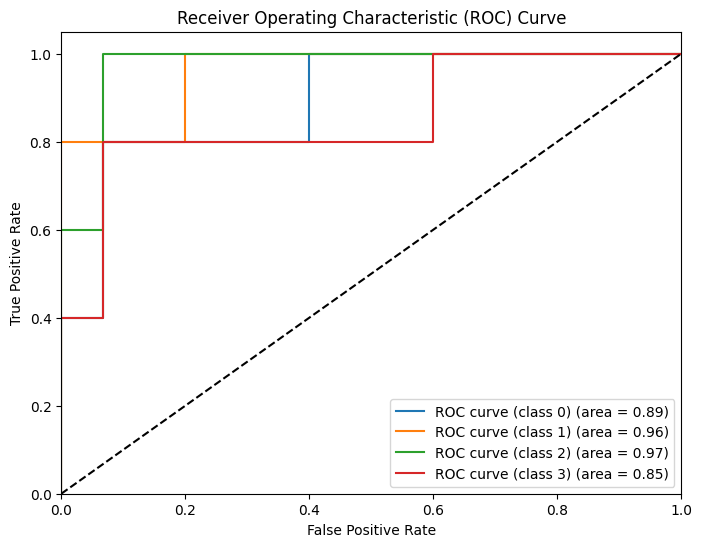

In [77]:
view_roc_curve_nn(true_labels, y_pred_prob)

По указанным значениям видно, что модель достаточно хорошо умеет различать эмоции. Лучше всего она умеет распознавать грусть и радость.

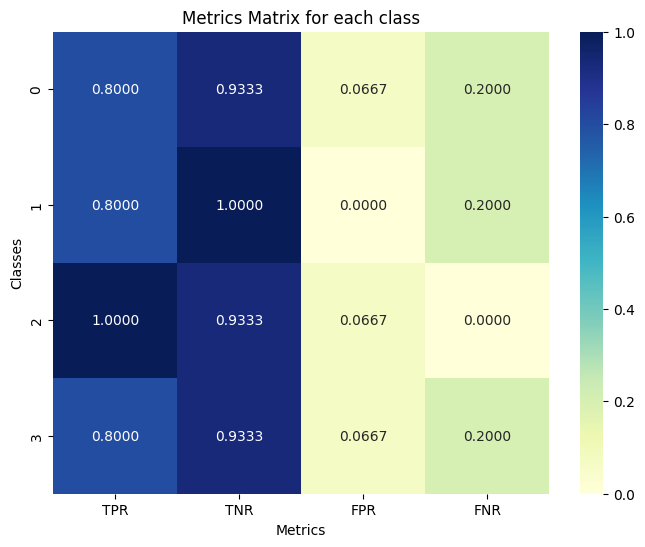

In [78]:
plot_metrics_matrix(true_labels, test_predictions)

Модель лучше всего умеет различать радость от других эмоций, отлично отличает другие эмоции от грусти, неплохо различает гнев и страх.

### Модель 5.

Сверточная нейронная сеть c 4 сверточными слоями и 1 линейным.

На выходе - логарифм функции softmax от линейного преобразования.

Функция активации - leakyrelu1 (лучше всего работает)

Функция потерь - Negative Log Likelihood Loss для log_softmax.

Оптимизатор - AdamW.

В ходе экспериментов log_softmax на выходе работает лучше, чем softmax.

In [90]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(11, 8, kernel_size=5, stride=2, padding=2)
        self.leakyrelu1 = nn.LeakyReLU(negative_slope=0.1)
        self.bn1 = nn.BatchNorm2d(8)
        nn.init.kaiming_normal_(self.conv1.weight, a=0.1)
        self.conv1.bias.data.zero_()

        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1)
        self.leakyrelu2 = nn.LeakyReLU(negative_slope=0.1)
        self.bn2 = nn.BatchNorm2d(16)
        nn.init.kaiming_normal_(self.conv2.weight, a=0.1)
        self.conv2.bias.data.zero_()

        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.leakyrelu3 = nn.LeakyReLU(negative_slope=0.1)
        self.bn3 = nn.BatchNorm2d(32)
        nn.init.kaiming_normal_(self.conv3.weight, a=0.1)
        self.conv3.bias.data.zero_()

        self.conv4 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.leakyrelu4 = nn.LeakyReLU(negative_slope=0.1)
        self.bn4 = nn.BatchNorm2d(64)
        nn.init.kaiming_normal_(self.conv4.weight, a=0.1)
        self.conv4.bias.data.zero_()

        self.ap = nn.AdaptiveAvgPool2d(output_size=1)
        self.lin = nn.Linear(64, 4)

    def forward(self, x):
        batch_size = x.size(0)
        seq_len = x.size(1)
        x = x.unsqueeze(2)
        x = x.unsqueeze(2)
        x = self.conv1(x)
        x = self.leakyrelu1(x)
        x = self.bn1(x)
        x = self.conv2(x)
        x = self.leakyrelu2(x)
        x = self.bn2(x)
        x = self.conv3(x)
        x = self.leakyrelu3(x)
        x = self.bn3(x)
        x = self.conv4(x)
        x = self.leakyrelu4(x)
        x = self.bn4(x)
        x = self.ap(x)
        x = x.view(batch_size, -1)
        x = self.lin(x)
        x = F.log_softmax(x, dim=1)
        return x

In [93]:
loss_fn = nn.NLLLoss()
model = CNN()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

In [94]:
n_epochs = 100
train_model(model, train_dataloader, loss_fn, optimizer, n_epochs)

Epoch 1: train accuracy 0.2593, test accuracy 0.3000
Epoch 2: train accuracy 0.4167, test accuracy 0.5500
Epoch 3: train accuracy 0.4074, test accuracy 0.4500
Epoch 4: train accuracy 0.4444, test accuracy 0.4000
Epoch 5: train accuracy 0.4352, test accuracy 0.4000
Epoch 6: train accuracy 0.4630, test accuracy 0.4500
Epoch 7: train accuracy 0.4722, test accuracy 0.4500
Epoch 8: train accuracy 0.5556, test accuracy 0.5000
Epoch 9: train accuracy 0.5741, test accuracy 0.5000
Epoch 10: train accuracy 0.5833, test accuracy 0.7000
Epoch 11: train accuracy 0.6111, test accuracy 0.6500
Epoch 12: train accuracy 0.6019, test accuracy 0.6000
Epoch 13: train accuracy 0.6204, test accuracy 0.6500
Epoch 14: train accuracy 0.6389, test accuracy 0.6500
Epoch 15: train accuracy 0.6204, test accuracy 0.7500
Epoch 16: train accuracy 0.6852, test accuracy 0.8000
Epoch 17: train accuracy 0.7130, test accuracy 0.8000
Epoch 18: train accuracy 0.7500, test accuracy 0.8000
Epoch 19: train accuracy 0.7778, test

CNN(
  (conv1): Conv2d(11, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (relu1): LeakyReLU(negative_slope=0.1)
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (relu2): LeakyReLU(negative_slope=0.1)
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (relu3): LeakyReLU(negative_slope=0.1)
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (relu4): LeakyReLU(negative_slope=0.1)
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (ap): AdaptiveAvgPool2d(output_size=1)
  (lin): Linear(in_features=64, out_features=4, bias=True)
)

In [95]:
test_predictions, true_labels, y_pred_prob = get_predictions(model, test_dataloader)

accuracy = calculate_accuracy(test_predictions, true_labels)
roc_auc = calculate_roc_auc(y_pred_prob, true_labels)
precision = calculate_precision(test_predictions, true_labels)
recall = calculate_recall(test_predictions, true_labels)
f1 = calculate_f1_score(test_predictions, true_labels)

print("CNN")
print(f'Accuracy: {accuracy}')
print(f'ROC AUC: {roc_auc}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

CNN
Accuracy: 0.9
ROC AUC: 0.9283333333333333
Precision: 0.9285714285714285
Recall: 0.9
F1 Score: 0.9027777777777779


Accuracy - хорошо

Roc_auc - хорошо

Precision, Recall, F1 - хорошо

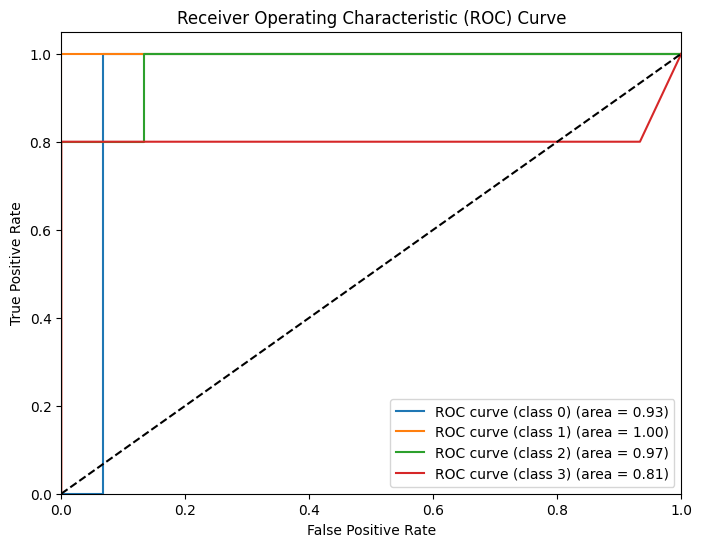

In [96]:
view_roc_curve_nn(true_labels, y_pred_prob)

По указанным значениям видно, что модель достаточно хорошо умеет различать эмоции. Лучше всего она умеет распознавать грусть и радость.

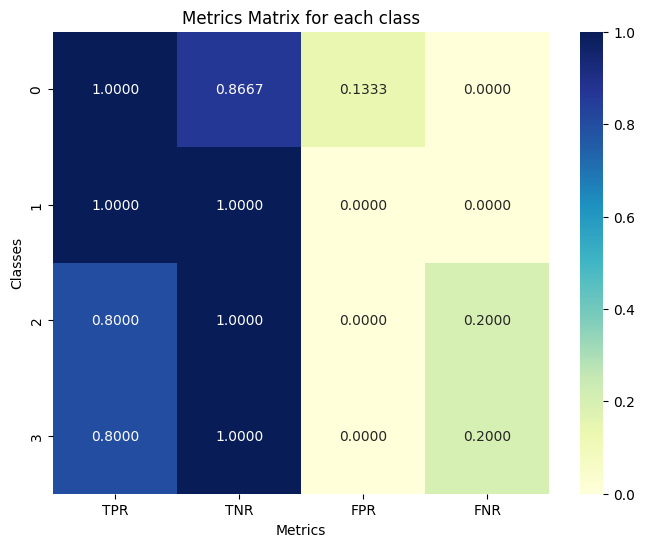

In [97]:
plot_metrics_matrix(true_labels, test_predictions)

Модель лучше всего умеет различать гнев и грусть от других эмоций, отлично отличает другие эмоции от радости и страха.

### Итог

Что получилось: получить неплохие результаты, извлечь нужные свойства для классификации аудио с речью, использовать и получить неплохие результаты с помощью различных видов нейросетей.<br>

Что не получилось: до конца пока не ясно, какие именно свойства и в какой мере влияют на качество моделей.

Среди классических алгоритмов лучше всего показал себя градиентный бустинг, среди нейронок - сверточная.
